In [43]:
import gymnasium as gym
from src.envs.make_env import make_env, make_vec_env
from src.agents.stochastic_agent import StochasticAgent
from src.networks.policy_network import PolicyNetwork, ValueNetwork
from src.training.REINFORCE_trainer import Trainer as REINFORCETrainer
from src.training.A2C_trainer import Trainer as A2CTrainer
import matplotlib.pyplot as plt
import numpy as np

## Hyperparameters Configuration

Modify these values to tune the training process:

In [ ]:
# ============ MODEL SELECTION ============
model_type = "A2C"  # Options: "REINFORCE", "A2C"

# ============ TRAINING HYPERPARAMETERS ============
# Environment
num_episodes = 3000  # Total number of training episodes (for REINFORCE) or total steps / avg_ep_len (for A2C)
log_interval = 20  # Print stats every N episodes

# Training
learning_rate = 0.0003  # Actor learning rate (policy network)
gamma = 0.99  # Discount factor
max_grad_norm = 2.0  # Max norm for gradient clipping (set to None or 0 to disable)

# Baseline (REINFORCE with baseline for variance reduction)
baseline = False  # Only used for REINFORCE
value_learning_rate = 0.0005  # Learning rate for value/critic network

# ============ A2C SPECIFIC HYPERPARAMETERS ============
n_envs = 1  # Number of parallel environments
n_steps = 10  # N-step returns for advantage calculation
train_every = 1  # Update networks every N steps (batch from steps 0, 4, 8...)

## Initialize Components

In [45]:
# Initialize Policy Network
policy_network = PolicyNetwork(input_size=8, output_size=4)

# Initialize Value Network (for baseline in REINFORCE or critic in Actor-Critic)
use_value_network = baseline or model_type == "A2C"
value_network = ValueNetwork(input_size=8) if use_value_network else None

# Initialize trainer based on model_type
if model_type == "REINFORCE":
    # Initialize agent (only for REINFORCE single-env training)
    agent = StochasticAgent(action_space=4, policy_network=policy_network)
    
    trainer = REINFORCETrainer(
        policy_network, 
        learning_rate=learning_rate, 
        gamma=gamma,
        baseline=baseline,
        value_network=value_network,
        value_learning_rate=value_learning_rate,
        max_grad_norm=max_grad_norm
    )
    # Create single environment
    env = make_env(render_mode="rgb_array")
    
    if baseline:
        print(f"🟣 Using REINFORCE Trainer with Baseline (Policy Gradient + Value Network)")
    else:
        print(f"🟣 Using REINFORCE Trainer (Policy Gradient)")

elif model_type == "A2C":
    if value_network is None:
        raise ValueError("A2C requires a value network")
    
    trainer = A2CTrainer(
        policy_network=policy_network,
        value_network=value_network,
        actor_learning_rate=learning_rate,
        critic_learning_rate=value_learning_rate,
        gamma=gamma,
        n_steps=n_steps,
        n_envs=n_envs,
        max_grad_norm=max_grad_norm
    )
    # Create vectorized parallel environments
    env = make_vec_env(n_envs=n_envs, render_mode=None)
    
    print(f"🔵 Using A2C Trainer (N-step Advantage Actor-Critic)")
    print(f"   📊 Parallel environments: {n_envs}")
    print(f"   📊 N-step returns: {n_steps}")
    print(f"   📊 Train every: {train_every} steps")
    print(f"   📊 Target episodes: {num_episodes}")
else:

    raise ValueError(f"Unknown model_type: {model_type}. Use 'REINFORCE' or 'A2C'")

🔵 Using A2C Trainer (N-step Advantage Actor-Critic)
   📊 Parallel environments: 1
   📊 N-step returns: 5
   📊 Train every: 1 steps
   📊 Target episodes: 3000


In [46]:
import csv
import os
import pandas as pd
from src.training.episode_outcome import categorize_episode_outcome, get_outcome_icon

# ===== AUTO-INCREMENT RUN ID =====
configs_file = 'runs/all_configs_combined.csv'
runs_file = 'runs/all_runs_combined.csv'

# Read existing configs to find last run_id
df_configs = pd.read_csv(configs_file, dtype={'run_id': str})
last_run_id = df_configs['run_id'].astype(int).max()
new_run_id = str(last_run_id + 1).zfill(2)

print(f"📋 Last run_id found: {last_run_id:02d}")
print(f"🆕 New run_id: {new_run_id}")

# ===== APPEND NEW CONFIG TO all_configs_combined.csv =====
# Policy gradient methods use different hyperparameters - fill DQN-specific ones with NA
new_config = {
    'run_id': new_run_id,
    'model_type': model_type,
    'num_episodes': num_episodes,
    'log_interval': log_interval,
    'train_every': train_every if model_type == 'A2C' else 'NA',
    'batch_size': n_envs if model_type == 'A2C' else 'NA',
    'learning_rate': learning_rate,
    'gamma': gamma,
    'update_mode': 'NA',  # Not used in policy gradient methods
    'tau': 'NA',  # Not used in policy gradient methods
    'target_update_freq': 'NA',  # Not used in policy gradient methods
    'replay_buffer_size': 'NA',  # Not used in policy gradient methods
    'epsilon_starting_value': 'NA',  # Not used in policy gradient methods
    'epsilon_ending_value': 'NA',  # Not used in policy gradient methods
    'epsilon_decay_value': 'NA',  # Not used in policy gradient methods
    'baseline': baseline if model_type == 'REINFORCE' else 'NA',
    'value_lr': value_learning_rate if (baseline or model_type == 'A2C') else 'NA',
    'n_envs': n_envs if model_type == 'A2C' else 'NA',
    'n_steps': n_steps if model_type == 'A2C' else 'NA',
    'max_grad_norm': max_grad_norm if max_grad_norm else 'NA'
}

# Append to configs file
new_config_df = pd.DataFrame([new_config])
new_config_df.to_csv(configs_file, mode='a', header=False, index=False)
print(f"✅ Config appended to {configs_file}")

# ===== SETUP LOG FILE =====
run_list_dir = 'runs/sample_runs_list'
os.makedirs(run_list_dir, exist_ok=True)
log_file = f'{run_list_dir}/run{new_run_id}.csv'

with open(log_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['episode', 'reward', 'length', 'terminated', 'truncated', 'outcome'])

print(f"📁 Log file created: {log_file}")

📋 Last run_id found: 36
🆕 New run_id: 37
✅ Config appended to runs/all_configs_combined.csv
📁 Log file created: runs/sample_runs_list/run37.csv


## Training Loop with Visualization

In [47]:
# Training loop with episode outcome logging
episode_rewards = []
episode_outcomes = []
episode_losses = []
episode_logs = []  # Store logs for appending to combined file

if model_type == "REINFORCE":
    # =====================================================
    # REINFORCE Training Loop (single environment)
    # =====================================================
    print(f"🚀 Starting REINFORCE training for Run {new_run_id}...\n")
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        total_reward = 0.0
        terminated = False
        truncated = False
        episode_length = 0
        final_obs = obs
        last_step_reward = 0.0
        
        # Reset episode data in trainer
        trainer.reset_episode()

        while not (terminated or truncated):
            # Ask agent for action
            action = agent.act(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # Store last step reward (used for outcome classification)
            last_step_reward = reward
            trainer.store_transition(obs, action, reward)

            total_reward += reward
            episode_length += 1
            obs = next_obs
            final_obs = next_obs

        # Update policy at end of episode
        loss = trainer.train_step()
        
        episode_rewards.append(total_reward)
        episode_losses.append(loss)

        # Categorize episode outcome
        outcome = categorize_episode_outcome(final_obs, episode_length, last_step_reward)
        episode_outcomes.append(outcome)

        # Store log entry
        log_entry = {
            'run_id': new_run_id,
            'episode': episode + 1,
            'reward': round(total_reward, 2),
            'length': episode_length,
            'terminated': int(terminated),
            'truncated': int(truncated),
            'outcome': outcome
        }
        episode_logs.append(log_entry)

        # Log to individual run CSV file
        with open(log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([episode + 1, f"{total_reward:.2f}", episode_length,
                             int(terminated), int(truncated), outcome])

        # Print individual episode result
        outcome_icon = get_outcome_icon(outcome)
        print(
            f"Episode {episode + 1:4d} | Steps: {episode_length:4d} | Reward: {total_reward:7.2f} | "
            f"Loss: {loss:7.4f} | {outcome_icon} {outcome.replace('_', ' ').title()}"
        )

        # Log average reward every N episodes
        if (episode + 1) % log_interval == 0:
            avg_reward = sum(episode_rewards[-log_interval:]) / log_interval
            avg_loss = sum(episode_losses[-log_interval:]) / log_interval

            recent_outcomes = episode_outcomes[-log_interval:]
            outcome_counts = {
                'success': recent_outcomes.count('landed_success'),
                'crashed': recent_outcomes.count('crashed'),
                'out_of_bounds': recent_outcomes.count('out_of_bounds'),
                'time_limit': recent_outcomes.count('time_limit')
            }

            print(
                f"  └─ Avg Reward: {avg_reward:7.3f} | Avg Loss: {avg_loss:7.4f} | "
                f"Success: {outcome_counts['success']}, "
                f"Crashed: {outcome_counts['crashed']}, "
                f"Out of bounds: {outcome_counts['out_of_bounds']}, "
                f"Time limit: {outcome_counts['time_limit']}"
            )
            print()

elif model_type == "A2C":
    # =====================================================
    # A2C Training Loop (parallel environments with n-step)
    # =====================================================
    print(f"🚀 Starting A2C training for Run {new_run_id}...\n")
    print(f"   Target episodes: {num_episodes}")
    print(f"   Environments: {n_envs} parallel")
    print(f"   N-step returns: {n_steps}")
    print(f"   Train every: {train_every} steps\n")
    
    # Initialize environments
    obs, info = env.reset()
    episode_count = 0
    global_step = 0
    
    # Track rewards per environment
    env_episode_rewards = [0.0 for _ in range(n_envs)]
    env_episode_lengths = [0 for _ in range(n_envs)]
    env_last_step_rewards = [0.0 for _ in range(n_envs)]
    env_final_obs = [obs[i] for i in range(n_envs)]
    
    while episode_count < num_episodes:
        # Select actions for all environments
        actions, log_probs, values, _ = trainer.select_actions(obs)
        
        # Step all environments
        next_obs, rewards, terminateds, truncateds, infos = env.step(actions)
        dones = np.logical_or(terminateds, truncateds)
        
        # Store transition
        trainer.store_transition(obs, actions, rewards, dones, values, log_probs)
        
        # Track per-environment episode data
        for i in range(n_envs):
            env_episode_rewards[i] += rewards[i]
            env_episode_lengths[i] += 1
            env_last_step_rewards[i] = rewards[i]
            env_final_obs[i] = next_obs[i]
            
            if dones[i]:
                # Episode completed for environment i
                total_reward = env_episode_rewards[i]
                episode_length = env_episode_lengths[i]
                final_obs_i = env_final_obs[i]
                last_step_reward = env_last_step_rewards[i]
                
                episode_count += 1
                episode_rewards.append(total_reward)
                
                # Categorize outcome
                outcome = categorize_episode_outcome(final_obs_i, episode_length, last_step_reward)
                episode_outcomes.append(outcome)
                
                # Store log entry
                log_entry = {
                    'run_id': new_run_id,
                    'episode': episode_count,
                    'reward': round(total_reward, 2),
                    'length': episode_length,
                    'terminated': int(terminateds[i]),
                    'truncated': int(truncateds[i]),
                    'outcome': outcome
                }
                episode_logs.append(log_entry)
                
                # Log to individual run CSV file
                with open(log_file, 'a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow([episode_count, f"{total_reward:.2f}", episode_length,
                                     int(terminateds[i]), int(truncateds[i]), outcome])
                
                # Reset tracking for this environment
                env_episode_rewards[i] = 0.0
                env_episode_lengths[i] = 0
                
                # Print episode result
                outcome_icon = get_outcome_icon(outcome)
                print(
                    f"Episode {episode_count:4d} | Env {i} | Steps: {episode_length:4d} | "
                    f"Reward: {total_reward:7.2f} | {outcome_icon} {outcome.replace('_', ' ').title()}"
                )
                
                # Log average every N episodes
                if episode_count % log_interval == 0 and episode_count > 0:
                    avg_reward = np.mean(episode_rewards[-log_interval:])
                    stats = trainer.get_episode_stats()
                    
                    recent_outcomes = episode_outcomes[-log_interval:]
                    outcome_counts = {
                        'success': recent_outcomes.count('landed_success'),
                        'crashed': recent_outcomes.count('crashed'),
                        'out_of_bounds': recent_outcomes.count('out_of_bounds'),
                        'time_limit': recent_outcomes.count('time_limit')
                    }
                    
                    print(
                        f"  └─ Step: {global_step:6d} | Avg Reward: {avg_reward:7.3f} | "
                        f"Actor Loss: {stats['avg_actor_loss']:.4f} | Critic Loss: {stats['avg_critic_loss']:.4f}"
                    )
                    print(
                        f"     Success: {outcome_counts['success']}, Crashed: {outcome_counts['crashed']}, "
                        f"OOB: {outcome_counts['out_of_bounds']}, Timeout: {outcome_counts['time_limit']}"
                    )
                    print()
        
        # Train step (updates when buffer is full)
        train_result = trainer.train_step(next_obs, dones)
        if train_result is not None:
            episode_losses.append(train_result['actor_loss'])
        
        obs = next_obs
        global_step += n_envs  # Each step processes n_envs transitions

env.close()

# ===== APPEND LOGS TO all_runs_combined.csv =====
logs_df = pd.DataFrame(episode_logs)
logs_df.to_csv(runs_file, mode='a', header=False, index=False)
print(f"✅ Logs appended to {runs_file}")

num_episodes_actual = len(episode_rewards)
print(f"\n✅ Training completed for Run {new_run_id}!")
print(f"Model type: {model_type}")
print(f"Total episodes: {num_episodes_actual}")
if model_type == "A2C":
    print(f"Total timesteps: {global_step}")

# Final statistics
success_count = episode_outcomes.count('landed_success')
crashed_count = episode_outcomes.count('crashed')
out_of_bounds_count = episode_outcomes.count('out_of_bounds')
time_limit_count = episode_outcomes.count('time_limit')

print(f"\n📊 Episode Outcomes:")
print(f"  🚀 Landed successfully: {success_count} ({100*success_count/num_episodes_actual:.1f}%)")
print(f"  💥 Crashed: {crashed_count} ({100*crashed_count/num_episodes_actual:.1f}%)")
print(f"  📍 Out of bounds: {out_of_bounds_count} ({100*out_of_bounds_count/num_episodes_actual:.1f}%)")
print(f"  ⏱️  Time limit: {time_limit_count} ({100*time_limit_count/num_episodes_actual:.1f}%)")
print(f"\n📁 Individual log saved to: {log_file}")
print(f"📁 Combined logs updated: {runs_file}")
print(f"📁 Configs updated: {configs_file}")

🚀 Starting A2C training for Run 37...

   Target episodes: 3000
   Environments: 1 parallel
   N-step returns: 5
   Train every: 1 steps

Episode    1 | Env 0 | Steps:   78 | Reward:  -67.66 | 🔴 Crashed
Episode    2 | Env 0 | Steps:   95 | Reward: -230.35 | 🔴 Crashed
Episode    3 | Env 0 | Steps:   81 | Reward: -228.50 | 🔴 Crashed
Episode    4 | Env 0 | Steps:   67 | Reward:  -95.43 | 🔴 Crashed
Episode    5 | Env 0 | Steps:   93 | Reward: -334.27 | 🟡 Out Of Bounds
Episode    6 | Env 0 | Steps:   67 | Reward:  -94.78 | 🔴 Crashed
Episode    7 | Env 0 | Steps:  128 | Reward:  -91.60 | 🔴 Crashed
Episode    8 | Env 0 | Steps:  114 | Reward: -256.42 | 🔴 Crashed
Episode    9 | Env 0 | Steps:   86 | Reward: -480.20 | 🔴 Crashed
Episode   10 | Env 0 | Steps:  102 | Reward: -252.65 | 🟡 Out Of Bounds
Episode   11 | Env 0 | Steps:   76 | Reward:  -87.65 | 🔴 Crashed
Episode   12 | Env 0 | Steps:   94 | Reward: -328.31 | 🟡 Out Of Bounds
Episode   13 | Env 0 | Steps:   93 | Reward: -116.61 | 🔴 Crashed

## Plot Training Progress

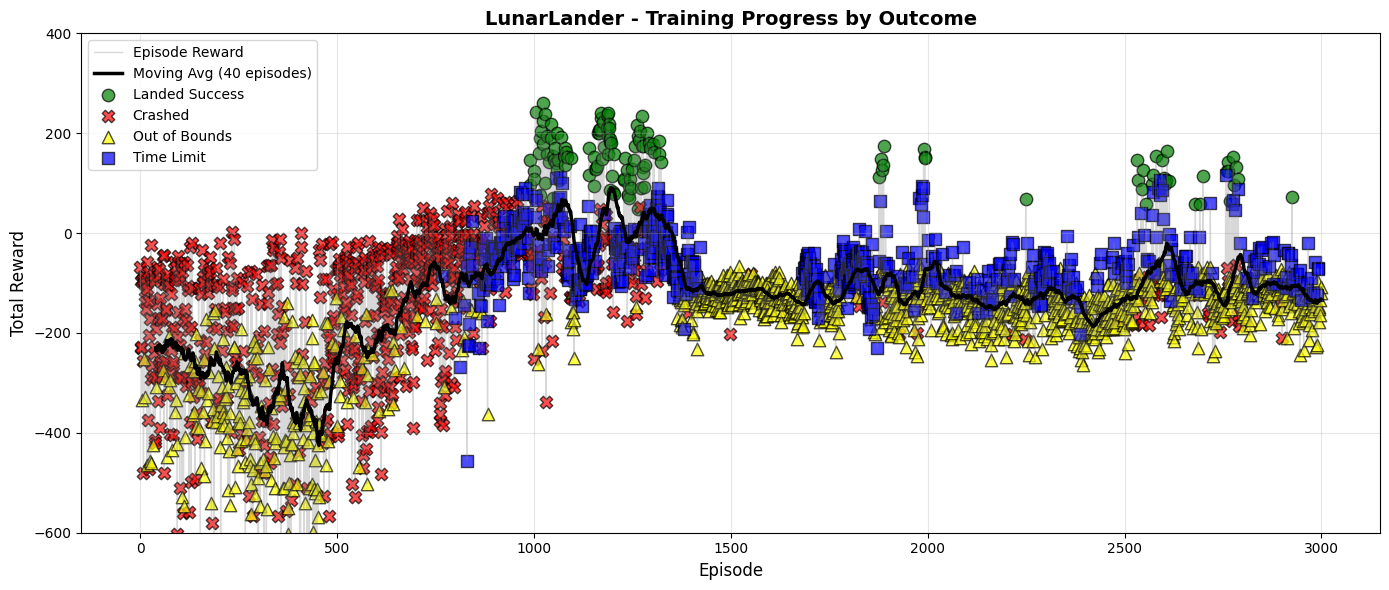


📊 Training Statistics:
  Average Reward: -129.400
  Max Reward: 259.532
  Min Reward: -736.967
  Std Dev: 132.135


In [48]:
# Plot episode rewards over time with outcome colors and different markers
fig, ax = plt.subplots(figsize=(14, 6))

# Base line plot
ax.plot(episode_rewards, alpha=0.3, label='Episode Reward', linewidth=1, color='gray')

# Plot moving average
window = 40
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(episode_rewards)), moving_avg, linewidth=2.5, 
         label=f'Moving Avg ({window} episodes)', color='black')

# Color and marker mapping for outcomes
outcome_styles = {
    'landed_success': {'color': 'green', 'marker': 'o', 'label': 'Landed Success'},
    'crashed': {'color': 'red', 'marker': 'X', 'label': 'Crashed'},
    'out_of_bounds': {'color': 'yellow', 'marker': '^', 'label': 'Out of Bounds'},
    'time_limit': {'color': 'blue', 'marker': 's', 'label': 'Time Limit'}
}

# Plot scatter points with different markers for each outcome
for outcome, style in outcome_styles.items():
    episodes = [i for i, o in enumerate(episode_outcomes) if o == outcome]
    rewards = [episode_rewards[i] for i in episodes]
    ax.scatter(episodes, rewards, c=style['color'], marker=style['marker'], 
              label=style['label'], s=80, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Total Reward', fontsize=12)
ax.set_title('LunarLander - Training Progress by Outcome', fontsize=14, fontweight='bold')
ax.set_ylim(-600, 400)
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Training Statistics:")
print(f"  Average Reward: {np.mean(episode_rewards):.3f}")
print(f"  Max Reward: {np.max(episode_rewards):.3f}")
print(f"  Min Reward: {np.min(episode_rewards):.3f}")
print(f"  Std Dev: {np.std(episode_rewards):.3f}")

## Watch Trained Agent in Action

In [49]:
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
import glob
import gymnasium as gym
import torch

env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="videos",
    episode_trigger=lambda episode_id: True,
    name_prefix="trained_agent_reinforce"
)

obs, info = env.reset()

final_reward = 0.0
terminated = False
truncated = False
episode_steps = 0
final_obs = obs
last_step_reward = 0.0

# Use greedy policy (no sampling, just argmax)
while not (terminated or truncated):
    # Select best action (deterministic)
    with torch.no_grad():
        probs = policy_network.predict(obs)
        action = torch.argmax(probs, dim=-1).item()
    
    obs, reward, terminated, truncated, info = env.step(action)

    final_reward += reward
    episode_steps += 1
    final_obs = obs
    last_step_reward = reward

env.close()

# Categorize episode outcome
outcome = categorize_episode_outcome(
    final_obs,
    episode_steps,
    last_step_reward
)
outcome_icon = get_outcome_icon(outcome)

print(f"\n🎬 Trained Agent Performance:")
print(f" Total Reward: {final_reward:.3f}")
print(f" Episode Steps: {episode_steps}")
print(f" Outcome: {outcome_icon} {outcome.replace('_', ' ').title()}")

# Pick the newest video
video_path = max(glob.glob("videos/*.mp4"), key=lambda p: p)

HTML(f"""
<video width="600" controls autoplay loop>
    <source src="{video_path}" type="video/mp4">
</video>
""")

c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\DataScience_Unitn\Lunar_Lander_Reinforcement_Learning\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



🎬 Trained Agent Performance:
 Total Reward: -180.734
 Episode Steps: 547
 Outcome: 🟡 Out Of Bounds
